# **Entorno**

In [2]:
# https://www.properati.com.ar/data
! wget -O ar_properties.csv.gz -q https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz
! gzip -d -f ./ar_properties.csv.gz

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

import re

from sklearn.feature_extraction.text import CountVectorizer
#import datetime



In [4]:
pd.options.display.max_colwidth = -1

# **Lectura de datos**

In [4]:
df_properties = pd.read_csv('../ar_properties.csv', index_col="id")
df_apred = pd.read_csv('../a_predecir.csv', index_col="id")

In [108]:
df = df_properties.copy()
df_pred = df_apred.copy()

In [ ]:
df.head()

In [ ]:
df_pred.info()

In [ ]:
df.info()

# **Análisis del conjunto de datos**

## Ambientes

In [ ]:
df[(df["bañosxambiente"] > 1) & (df["rooms"] == 16)]

In [295]:
df.bañosxambiente.value_counts()

0.500000    36995
1.000000    27014
0.333333    18331
0.666667    11879
0.250000    4229 
            ...  
0.052632    1    
0.033333    1    
0.882353    1    
0.466667    1    
0.157895    1    
Name: bañosxambiente, Length: 68, dtype: int64

In [296]:
df.loc[df["bañosxambiente"] > 1,["rooms", "price"]].groupby(["rooms"]).count().sort_values(by="price", ascending=False)

,price
rooms,
1.0,456
4.0,310
3.0,210
2.0,110
5.0,68
6.0,4
16.0,1


In [279]:
df["2 ambientes"] = df.description.apply(lambda x: 1 if "2 ambientes" in x else 0)
#df["amb"] = df.description.apply(lambda x: 1 if "amb" in x else 0)

In [293]:
df[(df["2 ambientes"] == 1) & (df["rooms"] == 9)]["description"].iloc[2]

'Venta departamento  Reconquista 700 San Nicolas<br><br>Ubicada en calle Reconquista al 700 entre Córdoba y Viamonte ,  al frente, con  en segundo piso. Todo aire y luz! <br>Edificio de estilo del año 1900., techos con molduras, puertas de madera y pisos calcáreos y de  pinotea .<br>Posee balcones con persianas. <br><br>Actualmente funciona como oficina,  está distribuida en 5 ambientes de trabajo, algunos comunicados entre sí y  2 salas de reuniones. <br>Amplio hall de recepción. <br>Entrepiso con  2 ambientes adicionales  y toilette.<br>Dos baños con ventilacion al exterior y Kitchenette<br><br>Al frente la vista es abierta  al Claustro de Santa Catalina de Siena y a un gran estacionamiento.<br><br>Excelente ubicación a metros de Galerías Pacífico y Av. Leandro Alem,  próxima a Puerto Madero. <br> Hay estacionamiento a 50 m y numerosos medios de transporte.<br><br>Servicios individuales. Aires acondicionados frío/ calor. Totalmente eléctrica. Seguridad. Cámaras de seguridad y Portero

In [286]:
df.loc[df["2 ambientes"] == 1,["rooms", "price"]].groupby(["rooms"]).count().sort_values(by="price", ascending=False)

,price
rooms,
2.0,12208
1.0,1966
3.0,428
4.0,97
5.0,36
6.0,20
7.0,8
12.0,6
8.0,4


## Precio por m2

In [269]:
df_m2 = df.loc[(df.surface_covered.notnull()) & (df.surface_covered > 0)]

In [270]:
df_m2["m2"] = df_m2.price / df_m2.surface_covered

/tmp/ipykernel_79919/2211268282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m2["m2"] = df_m2.price / df_m2.surface_covered


In [271]:
df_m2[["l3","m2"]].groupby(["l3"]).mean().sort_values(by="m2",ascending=False)

,m2
l3,
Liniers,5532.598455
Mataderos,4072.473377
Puerto Madero,4017.502194
Villa Urquiza,3653.169679
Agronomía,3593.116387
Belgrano,3331.964858
Palermo,3309.459823
Nuñez,3279.087920
Colegiales,3065.370913


In [272]:
df_m2[df_m2.l3 == "Liniers"]

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,property_type,m2
id,,,,,,,,,,,,,
1ieYb5KXI+v3r8TJo3OeoQ==,-34.636104,-58.493931,Liniers,2.0,1.0,1.0,50.0,42.0,95000.0,Vta. Depto 2 amb. al frente c/Balcón - Velez S...,Venta Depto 2 ambientes al frente con amplio ...,Departamento,2261.904762
fjB/UwE4cRMvqLPrA3ECyA==,-34.639400,-58.521398,Liniers,1.0,1.0,1.0,30.0,27.0,48000.0,"Depto 1 amb. c/coc. indep, al frente c/balcon ...",Venta Depto 1 ambiente con Balcón al Frente.. ...,Departamento,1777.777778
tVEuesjxQtUmltu9Mf4wGQ==,-34.643888,-58.517249,Liniers,1.0,NaN,1.0,43.0,30.0,95000.0,LINIERS: Excelente 1 Ambiente CON BALCON ATER...,LINIERS: Excelente Unidad de 1 Ambiente a EST...,Departamento,3166.666667
4spFzoAqpgtfnB8LtHQhsw==,-34.643888,-58.517249,Liniers,2.0,1.0,1.0,58.0,55.0,128000.0,LINIERS: Excelente Unidad de 2 Ambientes a EST...,"Excelente 2 Ambientes a ESTRENAR AL FRENTE, ed...",Departamento,2327.272727
XWgmdT/SjvL2hOvLR6ifIg==,-34.643888,-58.517249,Liniers,3.0,2.0,1.0,58.0,55.0,126000.0,LINIERS: Excelente 3 Ambientes a ESTRENAR,LINIERS: Excelente 3 Ambientes a ESTRENAR AL ...,Departamento,2290.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...
g3iQ3F0zG8ohNLcAgCN2ZQ==,-34.640201,-58.520914,Liniers,3.0,2.0,2.0,68.0,64.0,131900.0,PH EN DUPLEX 3 AMB. A ESTRENAR CON BALCON. LIN...,Corredor Responsable: Martin Macagno - CUCICBA...,PH,2060.937500
iVN3nPBfg4R80cVKs4i3tA==,-34.640201,-58.520914,Liniers,3.0,2.0,2.0,68.0,64.0,131900.0,PH EN DUPLEX 3 AMB. A ESTRENAR CON BALCON. LIN...,Corredor Responsable: Martin Macagno - CUCICBA...,Departamento,2060.937500
ylboR18W2ipyHndBo3JTVA==,-34.640201,-58.520914,Liniers,3.0,2.0,2.0,68.0,64.0,131900.0,PH EN DUPLEX 3 AMB. A ESTRENAR CON BALCON. LIN...,Corredor Responsable: Martin Macagno - CUCICBA...,Departamento,2060.937500


## Barrios a predecir

In [66]:
df_pred[df_pred.l3 == "Boca"]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
35,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.363134,-34.634496,Argentina,Capital Federal,Boca,3.0,...,"Hernandarias Al 1500 - PH en Venta en Boca, C...",Se trata de un Ph de 3ambientes al frente con ...,PH,Venta,"Superficie 66m2, Ambientes 3, Baños 1, Dormito...",Balcón,NaN,NaN,NaN,NaN
594,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.368129,-34.633506,Argentina,Capital Federal,Boca,6.0,...,Arzobispo Espinosa Al 1000 - PH en Venta en Bo...,PH 6 Ambientes en La Boca.<br>Living comedor.<...,PH,Venta,"Superficie 140m2, Ambientes 6, Baños 2, Dormit...","Patio, Terraza","Gas, Luz",NaN,NaN,NaN
715,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.364215,-34.637453,Argentina,Capital Federal,Boca,4.0,...,"Filiberto Al 1000 - PH en Venta en Boca, CABA...","Se trata de un hermoso PH de estilo, de 4 ambi...",PH,Venta,"Superficie 83m2, Ambientes 4, Baños 1, Dormito...",NaN,Luz,NaN,NaN,NaN
772,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.364459,-34.637280,Argentina,Capital Federal,Boca,3.0,...,Juan De Dios Filiberto Al 900 - PH en Venta en...,PH 3 amb impecable al frente sin expensas<br><...,PH,Venta,"Superficie 70m2, Ambientes 3, Baños 1, Dormito...",NaN,"Gas, Luz",NaN,NaN,NaN
968,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.363472,-34.633606,Argentina,Capital Federal,Boca,3.0,...,"Palos Al 200 - PH en Venta en Boca, CABA de 82...",Se trata de un 3 ambientes con patio mas un en...,PH,Venta,"Superficie 82m2, Ambientes 3, Baños 1, Dormito...",Aire Acondicionado,"Gas, Luz",NaN,NaN,NaN


In [77]:
df_pred.shape

(1087, 27)

In [84]:
df_pred[["l3","property_type"]].groupby(['l3']).count().sort_values(by='property_type', ascending=False).nlargest(23,"property_type")

,property_type
l3,
Palermo,205
Belgrano,110
Recoleta,97
Caballito,74
Villa Crespo,58
Almagro,57
Barracas,39
Flores,36
Nuñez,36


In [69]:
#analizamos los valores de las distintas variables
df.loc[df.l3 == "Boca",["l3","property_type","l2"]].groupby(['l3','property_type']).count().sort_values(by='l2', ascending=False)

l2
l3   property_type       
Boca Departamento     656
     PH                92
     Local comercial   84
     Casa              69
     Depósito          62
     Otro              58
     Lote              47
     Oficina           17
     Cochera            5

In [427]:
df_pred.l4.max()

34.819

In [428]:
df_pred.l4.min()

-38.0152022

## lon lat df_pred

In [19]:
print(f"lon max {abs(df_pred.lon).max()}")
print(f"lon min {abs(df_pred.lon).min()}")
print(f"lat max {abs(df_pred.lat).max()}")
print(f"lat min {abs(df_pred.lat).min()}")

lon max 38.0152022
lon min 26.8082848
lat max 65.2175903
lat min 57.5684538


## Outliers

In [ ]:
df_2 = df.copy()

df_2.dropna(subset="rooms", inplace=True)
df_2.dropna(subset="surface_total", inplace=True)

df_2 = df_2.loc[(df_2.rooms > 0) & (df_2.surface_total > 0)]

df_2["m2"] = df_2.surface_total/df_2.rooms

df_2.m2.max()
df_2.m2.min()


df_2[["m2", "l3"]].groupby(["l3"])



# **Tratamiento de nulls y outliers**

## *Longitud y Latitud*

In [109]:
df = df.loc[df["l1"] == "Argentina"]

In [110]:
df = df.loc[df["l2"] == "Capital Federal"]

Coordenadas maximas CABA: \
Norte - (-34.531639, -58.464800)\
Este - (-34.62073349940953, -58.338011418419356)\
Oeste - (-34.61568853226109, -58.532674897063565)\
Sur - (-34.7058110012102, -58.4602477739537)\
\
Limites:\
Longitud - (-58.532674897063565, -58.338011418419356 )\
Latitud - (-34.7058110012102, -34.531639)

In [387]:
lon_min_max = (-58.532674897063565, -58.338011418419356 )
lat_min_max = (-34.7058110012102, -34.531639)

In [388]:
df_lon_lat = df.loc[df["l2"] == "Capital Federal"]

In [389]:
df_lon_lat.drop(df_lon_lat.loc[df_lon_lat["lat"].isnull() & df_lon_lat["lon"].isnull() & df_lon_lat["l3"].isnull()].index, inplace = True)
df_lon_lat = df_lon_lat[["lat", "lon", "l3"]]
df_lon_lat["lat_outlier"] = df_lon_lat.lat.apply(lambda x: 0 if (x > lat_min_max[0]) & (x < lat_min_max[1]) else 1  )
df_lon_lat["lon_outlier"] = df_lon_lat.lon.apply(lambda x: 0 if (x > lon_min_max[0]) & (x < lon_min_max[1]) else 1 )

In [390]:
df_lon_lat.drop(df_lon_lat.loc[(df_lon_lat.lat_outlier == 1) & (df_lon_lat.l3.isnull())].index, inplace = True)
out_lon_lat_ind = df_lon_lat.loc[(df_lon_lat.lat_outlier == 1) | (df_lon_lat.lon_outlier == 1)].index
df_lon_lat_out = df_lon_lat.loc[(df_lon_lat.lat_outlier == 1) | (df_lon_lat.lon_outlier == 1)]
df_lon_lat = df_lon_lat.loc[(df_lon_lat.lat_outlier == 0) & (df_lon_lat.lon_outlier == 0)]

In [391]:
l3_list = list(df_lon_lat.l3.unique())
l3_dict_lat = {}
l3_dict_lon = {}
for i in l3_list:
    l3_dict_lon[i] = df_lon_lat.loc[df_lon_lat.l3 == i, "lon"].mean()
    l3_dict_lat[i] = df_lon_lat.loc[df_lon_lat.l3 == i, "lat"].mean()

df_lon_lat_out["lon"] = df_lon_lat_out.l3.apply(lambda x:l3_dict_lon[x])
df_lon_lat_out["lat"] = df_lon_lat_out.l3.apply(lambda x:l3_dict_lat[x])

In [392]:
for ind in out_lon_lat_ind:
    df["lon"].loc[ind] = df_lon_lat_out["lon"].loc[ind]
    df["lat"].loc[ind] = df_lon_lat_out["lat"].loc[ind]   

## *l3 - Barrio*

Corregidas las longitudes y latitudes generamos un knn para predecir los barrios y completar l3

In [393]:
df_l3 = df[["lon","lat","l3"]]

df_l3.drop(df_l3.loc[df_l3["lon"].isnull()].index,inplace = True)
df_l3.drop(df_l3.loc[df_l3["lat"].isnull()].index,inplace = True)

df_test_l3 = df_l3.loc[df_l3["l3"].isnull()]

df_train_l3 = df_l3.loc[df_l3["l3"].notnull()]

In [394]:
X_l3 = df_train_l3[df_train_l3.columns.drop('l3')]
y_l3 = df_train_l3['l3']

#Partimos en entrenamiento y prueba 

for i in [1]:
    # Creamos el objeto del modelo
    neigh = sk.neighbors.KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = []
    
    for train, test in kf.split(X_l3):
        
        X_train, X_test, y_train, y_test = X_l3.iloc[train], X_l3.iloc[test], y_l3[train], y_l3[test]
    
        # Entrenamos el modelo
        neigh.fit(X_train, y_train)
    
        # Predecimos
        y_pred_l3 = neigh.predict(X_test)
    
        # Medimos la performance de la predicción
        score = sk.metrics.accuracy_score(y_test, y_pred_l3)
        scores.append(score)
        #print(score)
    print(f"n_{i} {np.mean(scores)}")


n_1 0.8380804193175351


In [395]:
X_pred_l3 = df_test_l3[df_test_l3.columns.drop('l3')]

# Entrenamiento
neigh = sk.neighbors.KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

# Entrenamos el modelo
neigh.fit(X_train, y_train)

# predicción
df_test_l3["l3"] = neigh.predict(X_pred_l3)

In [396]:
df["l3"].loc[df["l3"].isnull()] = df_test_l3["l3"]

## *Elimino columnas columnas varias*

In [397]:
df.drop(columns = ["ad_type","l4","l5", "l6", "created_on","start_date", "end_date","l1","l2","price_period","operation_type"], inplace = True )

## *Precio y Moneda*

In [111]:
df.dropna(subset=["price"], inplace = True)
df.dropna(subset=["currency"], inplace = True)

In [11]:
#df.drop(df.loc[df["price"]> 6000000].index, inplace=True)

In [12]:
#df.drop(df[df.price < 15000.0].index,inplace = True)

In [112]:
df = df.loc[df["currency"] == "USD"]

df.drop(columns = ["currency"], inplace = True )

## *Limpieza Barrios*

In [20]:
barrios_list = list(df_pred.l3.unique())

df["barrios"] = df.l3.apply(lambda x: 1 if x in barrios_list else 0)

df = df.loc[df["barrios"] == 1]

df.drop(columns = "barrios", inplace = True)

In [19]:
df["property_type_check"] = df.property_type.apply(lambda x: 1 if x in ("Departamento","PH") else 0)

df = df.loc[df["property_type_check"] == 1]

df.drop(columns = "property_type_check", inplace = True)

## *Cuartos y baños*

In [403]:
df.drop(df.loc[df["rooms"].isnull() & df["bedrooms"].isnull() & df["bathrooms"].isnull() & df["surface_total"].isnull() & df["surface_covered"].isnull()].index, inplace = True)

In [404]:
df_pred["rooms"].fillna(0, inplace = True)
df_pred["bedrooms"].fillna(0, inplace = True)
df_pred["bathrooms"].fillna(0, inplace = True)

In [405]:
df["rooms"].fillna(0, inplace = True)
df["bedrooms"].fillna(0, inplace = True)
df["bathrooms"].fillna(0, inplace = True)

In [406]:
df["surface_total"].loc[df["surface_total"].isnull() & df["surface_covered"] > 0] = df["surface_covered"].loc[df["surface_total"].isnull() & df["surface_covered"] > 0]

df["surface_total"].fillna(0, inplace = True)
df["surface_covered"].fillna(0, inplace = True)

In [407]:
df["bedrooms"].loc[df["bedrooms"] < 0 ] = abs(df["bedrooms"].loc[df["bedrooms"] < 0 ])

## *Superficie*

In [408]:
df["surface_total"].loc[df["surface_total"] < 0 ] = abs(df["surface_total"].loc[df["surface_total"] < 0 ])

In [409]:
df["surface_covered"].loc[df["surface_covered"] < 0 ] = abs(df["surface_covered"].loc[df["surface_covered"] < 0 ])

In [410]:
max_scovered = df_pred.surface_covered.max()

df = df[df.surface_covered < max_scovered]


## *Strings*

In [411]:
df.drop(columns = ["title"], inplace = True)

## *Duplicados*

In [412]:
df.drop_duplicates(inplace = True)

## *Modifico el df_pred*

In [413]:
df_pred.drop(columns = ["ad_type","l4","l5", "l6", "created_on"], inplace = True )
df_pred.drop(columns = ["l1","l2"], inplace = True )
df_pred.drop(columns = ["currency"], inplace = True )
df_pred.drop(columns = ["price_period"], inplace = True)
df_pred.drop(columns = "operation_type", inplace = True)
df_pred.drop(columns = ["start_date","end_date","services"], inplace = True)
df_pred.drop(columns = ["title","details"], inplace = True)

In [414]:
df_pred.drop(columns = ["lat","lon"], inplace = True)

# **Feature Engineering**

Concateno los dataframes para que tengan las mismas columnas y las variables categoricas esten alineadas

In [415]:
df_total = pd.concat([df,df_pred], axis=0)

## Additionals

Genero dummies con los additionals y lo agrego en el df

In [416]:
df_pred.additionals.fillna("zxzyzjz", inplace = True)
df_pred.additionals_split = df_pred.additionals.apply(lambda x: x.split(","))

In [417]:
additionals_list = df_pred.additionals_split.explode().unique()
additionals_list = [x.strip() for x in additionals_list]
additionals_list = list(dict.fromkeys(additionals_list))
additionals_list.append("Subte")
additionals_list.append("Parrilla")

In [418]:
df_total.description.fillna("sin_descripcion", inplace = True)

In [419]:
for additional in additionals_list:
    df_total[additional] = df_total.description.apply(lambda x: 1 if additional.lower() in x.lower() else 0)

In [420]:
df_total.drop(columns = "zxzyzjz", inplace = True)
df_total.drop(columns = "additionals", inplace = True)
df_total.drop(columns = "description", inplace = True)

## cantidad ambientes

In [ ]:
df["monoambiente"] = df.description.apply(lambda x: 1 if "monoambiente" in x else 0)

In [ ]:
patron = "(\d|un|una|dos|tres|cuatro|cinco) ambient[e|es]"
df["cantidad_ambientes"] = df.description.apply(lambda x:re.findall(patron, x.lower()))

In [ ]:
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.join(" ")

In [ ]:
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("1", "uno")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("2", "dos")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("3", "tres")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("4", "cuatro")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("5", "cinco")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("6", "seis")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("7", "siete")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("8", "ocho")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("9", "nueve")
df["cantidad_ambientes"] = df["cantidad_ambientes"].str.replace("0", "cero")

In [ ]:


vectorizer = CountVectorizer(analyzer='word')
vectorized_data = vectorizer.fit_transform(df['cantidad_ambientes'])
vectorized_data.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
ambientes_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
ambientes_df.set_index(df.index, inplace = True)

In [ ]:
df = pd.concat([df,ambientes_df], axis = 1)

## logaritmicas

Esta sección por el momento está descartada

In [44]:
#df_total["lnrooms"] = df_total.rooms.apply(lambda x: x if x == 0 else np.log(x))

In [45]:
#df_total["lnbedrooms"] = df_total.bedrooms.apply(lambda x: x if x == 0 else np.log(x))

In [46]:
#df_total["lnsurface_covered"] = df_total.surface_covered.apply(lambda x: x if x == 0 else np.log(x))

In [47]:
#df_total["lnsurface_total"] = df_total.surface_total.apply(lambda x: x if x == 0 else np.log(x))

## Dummies

In [421]:
df_total = pd.get_dummies(df_total, columns = ["property_type"])

## Categoricas

### superficie por ambiente

Esta sección por ahora esta descartada

In [422]:
#df_pred.surface_covered.fillna(1, inplace=True)
#df_pred.rooms.fillna(1, inplace=True)
#df_pred["m2xcuarto"] = df_pred.surface_covered / df_pred.rooms

In [423]:
#m2_corte1 = np.quantile(df_pred.m2xcuarto,q=0.33)
#m2_corte2 = np.quantile(df_pred.m2xcuarto,q=0.66)
#m2_max = df_pred.drop(794)["m2xcuarto"].max()


In [424]:
#def dimension(x):
#    if x < m2_corte1:
#        return 1 #chico
#    elif x < m2_corte2:
#        return 2 #mediano
#    elif x < 190:
#        return 3 #grande
#    else:
#        return 4 #oversize

In [425]:
#df_total.surface_covered.fillna(1, inplace=True)
#df_total.rooms.fillna(1, inplace=True)
#df_total["m2xcuarto"] = df_total.surface_covered / df_pred.rooms
#df_total["dimensiones"] = df_total.m2xcuarto.apply(lambda x: dimension(x))

In [426]:
#df_total.drop(columns="m2xcuarto",inplace=True)

### Barrio

In [427]:
df_total.l3 = df_total.l3.astype("category").cat.codes

## Separo el dataframe nuevamente en df_pred y df

In [428]:
df = df_total[df_total.index.isin(df.index)]
df_pred = df_total[df_total.index.isin(df_pred.index)]

In [ ]:
df.info()

In [439]:
df.shape[]

(117937, 29)

# **Modelo**

In [440]:
X = df[df.columns.drop(['price','l3','dimensiones'])]
y = df['price']

for n_estimators in [50]:
    for max_depth in [12]:     

## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
#n_estimators = 5000
#max_depth = 5

        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)

        scores = []
        kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y[train], y[test]
        
            # Entrenamos el modelo
            reg.fit(X_train, y_train)
        
            # Predecimos
            y_pred = reg.predict(X_test)
        
            # Medimos la performance de la predicción
            score = sk.metrics.mean_squared_error(y_test, y_pred, squared=False)
            scores.append(score)
        print(f"max_depth:{max_depth} - mean: {np.mean(scores)} sd: {np.std(scores)}")
        
    #print(f"n_{n_estimators} - mean: {np.mean(scores)} sd: {np.std(scores)}")

max_depth:12 - mean: 184377.25652922728 sd: 6398.473938748867


## Predicción para Kaggle


In [200]:
# quedate con las mismas columnas que ar_properties
X_pred = df_pred[X.columns]
X_train = X
y_train = y

In [201]:
# los mejores hiperparámetros encontrados antes
n_estimators = 50
max_depth = 12

# Entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

# Entrenamos el modelo
reg.fit(X_train, y_train)

# predicción
df_pred["price"] = reg.predict(X_pred)

/tmp/ipykernel_79919/2319193158.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["price"] = reg.predict(X_pred)


In [202]:
# Grabo la solución
df_pred[["price"]].to_csv("../Soluciones/solucion.csv")

## Importancia de las variables

In [437]:
importances = reg.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

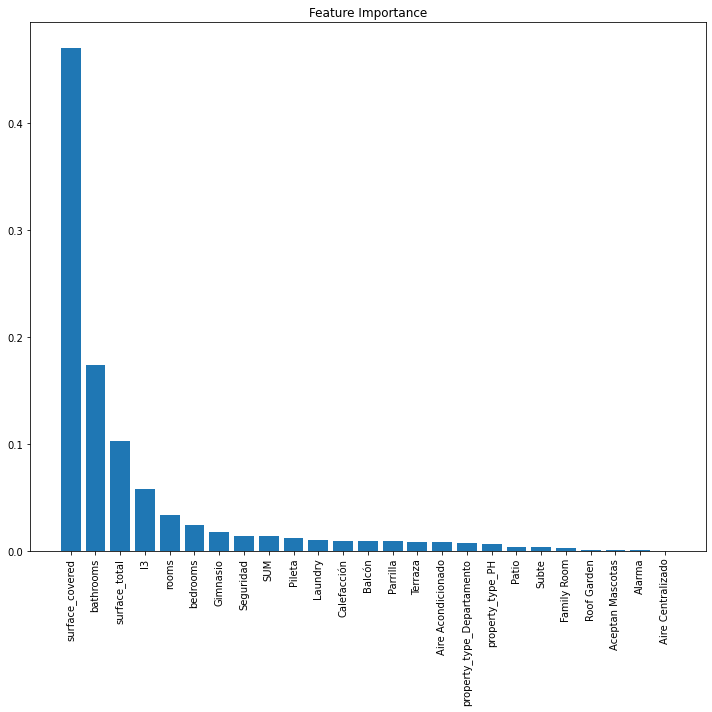

In [438]:
import matplotlib.pyplot as plt

f,a = plt.subplots(figsize=(10,10))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()